In [113]:
import pandas as pd
import matplotlib.pyplot as plt
import keras
from zipfile import ZipFile
import pickle
import numpy as np
from sklearn.preprocessing import StandardScaler
from keras.preprocessing import timeseries_dataset_from_array as ts_split
from keras import layers as kl

In [114]:
# Open the pickle file
df = pickle.load(open('../data/processed/stock_data_simple.pkl', 'rb'))
df

,AAL_Last,ALGT_Last,ALK_Last,DAL_Last,ITA_Last,IYT_Last,JBLU_Last,JETS_Last,LUV_Last,UAL_Last
Time,,,,,,,,,,
2022-05-05 09:30:00,19.3500,156.740,52.6100,43.3400,105.7100,61.3925,11.2600,21.520,47.6609,51.350
2022-05-05 09:45:00,19.2200,155.295,52.5016,43.2553,105.4000,61.3375,11.2500,21.445,47.5900,51.020
2022-05-05 10:00:00,19.1600,154.910,52.3480,43.1900,104.7200,61.1175,11.2099,21.390,47.6100,50.850
2022-05-05 10:15:00,19.0700,154.360,52.0500,42.9300,104.6400,60.8625,11.1400,21.270,47.3750,50.506
2022-05-05 10:30:00,19.1000,153.915,51.9000,42.8600,104.5600,60.7750,11.1400,21.270,47.3100,50.510
...,...,...,...,...,...,...,...,...,...,...
2025-05-30 14:45:00,11.4250,55.945,51.3300,48.3850,176.8500,65.4800,5.1300,22.675,33.4150,79.480
2025-05-30 15:00:00,11.4350,55.930,51.2850,48.4850,177.0475,65.4950,5.1100,22.690,33.4850,79.520
2025-05-30 15:15:00,11.4650,56.050,51.4100,48.6550,177.4300,65.6100,5.1250,22.740,33.5550,79.910


In [115]:
# Data preprocessing
# Forward fill missing values
df = df.ffill()

y_cols = ['AAL_Last']
#x_cols = ['AAL_Last','ALGT_Last','ALK_Last','DAL_Last','ITA_Last','IYT_Last','JBLU_Last','JETS_Last','LUV_Last','UAL_Last']
x_cols = ['AAL_Last']

y = df[y_cols]
x = df[x_cols]

In [116]:
# Train/text splitting
split_val  = round(0.7 * len(x))
split_test = round(0.9 * len(x))

x_train = x[:split_val]
x_val   = x[split_val:split_test]
x_test  = x[split_test:]

y_train = y[:split_val]
y_val   = y[split_val:split_test]
y_test  = y[split_test:]

In [117]:
# Normalize the features to mean=0 and std=1
sc = StandardScaler()

x_train = sc.fit_transform(x_train)
x_test  = sc.fit_transform(x_test)
x_val   = sc.fit_transform(x_val)
y_train = sc.fit_transform(y_train)
y_test  = sc.fit_transform(y_test)
y_val   = sc.fit_transform(y_val)

y_train

array([[ 3.14069416],
       [ 3.06018014],
       [ 3.02301983],
       ...,
       [-1.94252734],
       [-1.94407569],
       [-1.94413762]])

In [118]:
y_train.shape

(13968, 1)

In [119]:
x_train[0:2]

array([[3.14069416],
       [3.06018014]])

In [120]:
def create_tensor(data, type:str, steps_historical=100, steps_future=12, skiprows=1):
    # Need to fix skiprows to make the output data shorter

    tot_length = len(data) - steps_historical - steps_future + 1

    if type.lower() == 'x':
        x_tensor = np.zeros(shape=(tot_length, steps_historical, data.shape[1]))
        for i in range(0, tot_length, skiprows):
            j = i + steps_historical
            x_tensor[i] = data[i:j]
        return x_tensor
    
    elif type.lower() == 'y':
        y_tensor = np.zeros(shape=(tot_length, steps_future, data.shape[1]))
        for i in range(0, tot_length, skiprows):
            j = i + steps_historical
            k = j + steps_future
            y_tensor[i] = data[j:k]
        return y_tensor
    
    else:
        raise ValueError("Type must be 'x' or 'y'.")

In [121]:
steps_historical = 2
steps_future = 12

x_tensor_train = create_tensor(x_train, type='x', steps_historical=steps_historical, steps_future=steps_future)
x_tensor_test  = create_tensor(x_test , type='x', steps_historical=steps_historical, steps_future=steps_future)
x_tensor_val   = create_tensor(x_val  , type='x', steps_historical=steps_historical, steps_future=steps_future)
y_tensor_train = create_tensor(y_train, type='y', steps_historical=steps_historical, steps_future=steps_future)
y_tensor_test  = create_tensor(y_test , type='y', steps_historical=steps_historical, steps_future=steps_future)
y_tensor_val   = create_tensor(y_val  , type='y', steps_historical=steps_historical, steps_future=steps_future)

In [122]:
for i in ['x_tensor_train', 'x_tensor_test', 'x_tensor_val', 'y_tensor_train', 'y_tensor_test', 'y_tensor_val']:
    print(f"{i} shape: {eval(i).shape}")

x_tensor_train shape: (13955, 2, 1)
x_tensor_test shape: (1982, 2, 1)
x_tensor_val shape: (3978, 2, 1)
y_tensor_train shape: (13955, 12, 1)
y_tensor_test shape: (1982, 12, 1)
y_tensor_val shape: (3978, 12, 1)


In [123]:
y_tensor_val

array([[[-0.73192923],
        [-0.72858534],
        [-0.71120406],
        ...,
        [-0.69901278],
        [-0.69727117],
        [-0.71991211]],

       [[-0.72858534],
        [-0.71120406],
        [-0.72862017],
        ...,
        [-0.69727117],
        [-0.71991211],
        [-0.70225218]],

       [[-0.71120406],
        [-0.72862017],
        [-0.73210339],
        ...,
        [-0.71991211],
        [-0.70225218],
        [-0.68678667]],

       ...,

       [[ 1.38743709],
        [ 1.3891787 ],
        [ 1.39266193],
        ...,
        [ 1.15057801],
        [ 1.18541023],
        [ 1.16799412]],

       [[ 1.3891787 ],
        [ 1.39266193],
        [ 1.38388421],
        ...,
        [ 1.18541023],
        [ 1.16799412],
        [ 1.1645109 ]],

       [[ 1.39266193],
        [ 1.38388421],
        [ 1.38182911],
        ...,
        [ 1.16799412],
        [ 1.1645109 ],
        [ 1.17496056]]])

In [124]:
# Designing the model structure
model = keras.Sequential([
    kl.Input(shape=(steps_historical, len(x_cols))),
    kl.SimpleRNN(10, return_sequences=False),
    kl.Dense(len(y_cols))
])

model.compile(
    optimizer = 'adam', 
    loss = 'mean_squared_error'
    )
model.summary()

Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn_13 (SimpleRNN)       │ (None, 10)             │           120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 131 (524.00 B)

 Trainable params: 131 (524.00 B)

 Non-trainable params: 0 (0.00 B)

In [125]:
# This will monitor validation loss and stop training if it doesn't improve after 5 epochs
es_callback = keras.callbacks.EarlyStopping(monitor="val_loss", min_delta=0, patience=10)

history = model.fit(
    x_tensor_train, 
    y_tensor_train,
    validation_data = (x_tensor_val, y_tensor_val),
    epochs = 100, 
    verbose = 1,
    batch_size = None,
    callbacks = [es_callback])

Epoch 1/100


437/437 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.9358 - val_loss: 0.0093
Epoch 2/100
437/437 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0315 - val_loss: 0.0066
Epoch 3/100
437/437 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0204 - val_loss: 0.0062
Epoch 4/100
437/437 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0187 - val_loss: 0.0059
Epoch 5/100
437/437 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0163 - val_loss: 0.0058
Epoch 6/100
437/437 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0172 - val_loss: 0.0053
Epoch 7/100
437/437 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0161 - val_loss: 0.0050
Epoch 8/100
437/437 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0161 - val_loss: 0.0049
Epoch 9/100
437/437 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0156 - val_loss: 0.0049
Epoch 10/100
437/437 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0158 - val_loss: 0.0048
Epoch 11/100
437/437 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0156 - val_loss: 0.0047
Epoch 12/100
437/437 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step

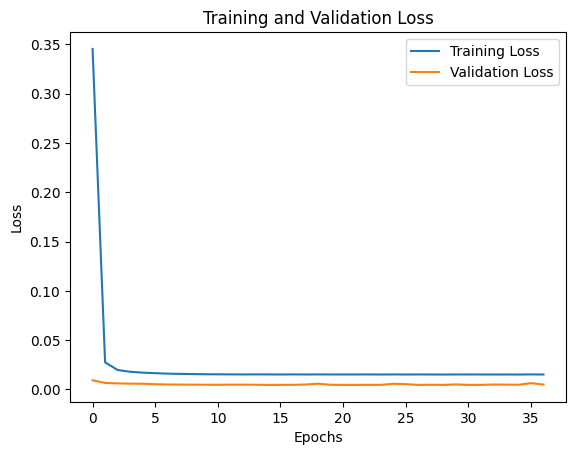

In [126]:
# Plot the training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [131]:
model.predict(x_tensor_val).flatten().shape

125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 697us/step


(3978,)

In [132]:
y_tensor_val

array([[[-0.73192923],
        [-0.72858534],
        [-0.71120406],
        ...,
        [-0.69901278],
        [-0.69727117],
        [-0.71991211]],

       [[-0.72858534],
        [-0.71120406],
        [-0.72862017],
        ...,
        [-0.69727117],
        [-0.71991211],
        [-0.70225218]],

       [[-0.71120406],
        [-0.72862017],
        [-0.73210339],
        ...,
        [-0.71991211],
        [-0.70225218],
        [-0.68678667]],

       ...,

       [[ 1.38743709],
        [ 1.3891787 ],
        [ 1.39266193],
        ...,
        [ 1.15057801],
        [ 1.18541023],
        [ 1.16799412]],

       [[ 1.3891787 ],
        [ 1.39266193],
        [ 1.38388421],
        ...,
        [ 1.18541023],
        [ 1.16799412],
        [ 1.1645109 ]],

       [[ 1.39266193],
        [ 1.38388421],
        [ 1.38182911],
        ...,
        [ 1.16799412],
        [ 1.1645109 ],
        [ 1.17496056]]])

125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


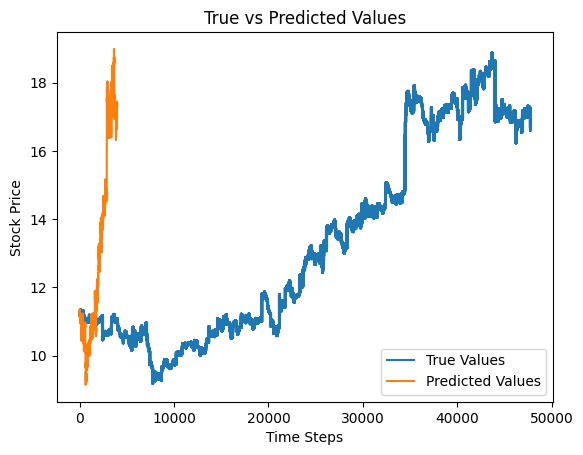

In [127]:
y_pred = model.predict(x_tensor_val).flatten()
y_pred = sc.inverse_transform(y_pred.reshape(-1, 1))


y_eval = sc.inverse_transform(y_tensor_val.flatten().reshape(-1, 1))

plt.plot(y_eval, label='True Values')
plt.plot(y_pred, label='Predicted Values')
plt.title('True vs Predicted Values')
plt.xlabel('Time Steps')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

In [128]:
predictions = pd.DataFrame(np.hstack((y_eval, y_pred)), columns=['True Values', 'Predicted Values'])
predictions['MAPE'] = 100 * abs((predictions['True Values'] - predictions['Predicted Values']) / predictions['True Values'])
predictions.mean()

ValueError: all the input array dimensions except for the concatenation axis must match exactly, but along dimension 0, the array at index 0 has size 47736 and the array at index 1 has size 3978

In [90]:
predictions

,True Values,Predicted Values,MAPE
0,19.677535,18.635502,5.295546
1,19.623557,18.628147,5.072527
2,19.549338,18.595335,4.879978
3,19.530581,18.543562,5.053712
4,19.583074,18.517843,5.439550
...,...,...,...
1940,12.822409,12.962421,1.091934
1941,12.835904,12.975033,1.083907
1942,12.876387,12.986683,0.856578
1943,12.856280,13.029459,1.347038


In [71]:
# Predicting on the test set and plotting the results
predictions = model.predict(dataset_test)
predictions = predictions.reshape(-1, len(y_cols))
# Inverse transform the predictions and actual values
predictions = sc.inverse_transform(predictions)
predictions

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


array([[13.398315 , 71.36834  , 54.333954 , ...,  6.145635 , 31.93161  ,
        81.79915  ],
       [13.290259 , 70.35036  , 54.740807 , ...,  6.1424336, 32.09865  ,
        81.15575  ],
       [13.225269 , 68.630714 , 55.365253 , ...,  6.1714272, 32.071114 ,
        80.89167  ],
       ...,
       [12.657994 , 72.1708   , 54.409004 , ...,  5.64687  , 31.43997  ,
        93.8736   ],
       [12.604883 , 71.907265 , 54.49948  , ...,  5.6565123, 31.443684 ,
        94.13033  ],
       [12.623931 , 71.81959  , 54.600266 , ...,  5.6525955, 31.446852 ,
        94.227844 ]], dtype=float32)